In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from datasets        import *
from lgcp2d          import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

from scipy.fft import *

# Set constants

In [2]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128       # Grid size ( bins per linear distance )
T      = L*L       # Total number of basis functions (bins per unit area)
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz ( samples/second )
Δt     = 1/Fs      # seconds / sample
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

cm  per spatial bin 3.1682123531314383
cm² per spatial bin 10.037569514534646
Period is 28.197090 cm (8.900000 bins)


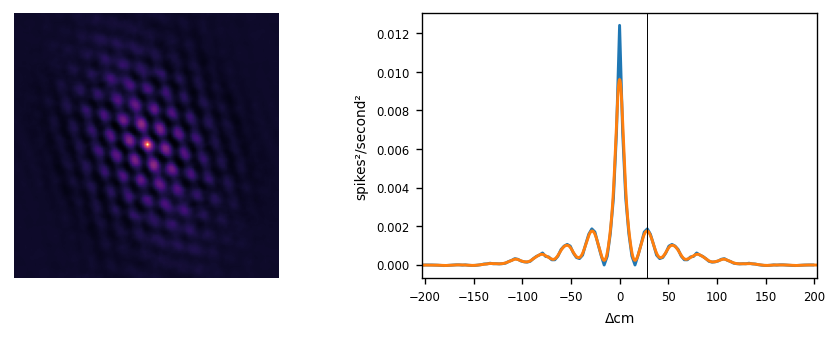

In [3]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'

# Get specific dataset
idata = 1
s,px,py,scale = load_dataset(datadir+dataset,1,pad)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm  per spatial bin',cm_p_bin)
print('cm² per spatial bin',cm_p_bin**2)

# Grab spikes
st    = find(s>0)                # samples with a spike
xs,ys = px[st],py[st]            # locations where spikes happened
sk    = s[st]                    # number of spikes per spike event
N,K   = bin_spikes(px,py,s,L)    # count number of visits and number of spikes per bin
mask  = blur(N>0,2)>0.1          # mask out areas with no data
Δx    = cm_p_bin**2              # cm² / bin
y     = float32(nan_to_num(K/N)) # spikes/second

# Calibrate grid scale
λhat   = y # spikes/second
acorr2 = fft_acorr(λhat,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins

subplot(121)
imshow(acorr2)
axis('off')
print('Period is %f cm (%f bins)'%(P*cm_p_bin,P))

subplot(122)
plot((arange(L)-L/2)*cm_p_bin,acorrR)
plot((linspace(-L/2,L/2,L*res))*cm_p_bin,acup)
xlim(-L/2*cm_p_bin,L/2*cm_p_bin)
xlabel('Δcm')
ylabel('spikes²/second²')
axvline(P*cm_p_bin,color='k',lw=0.5)

Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

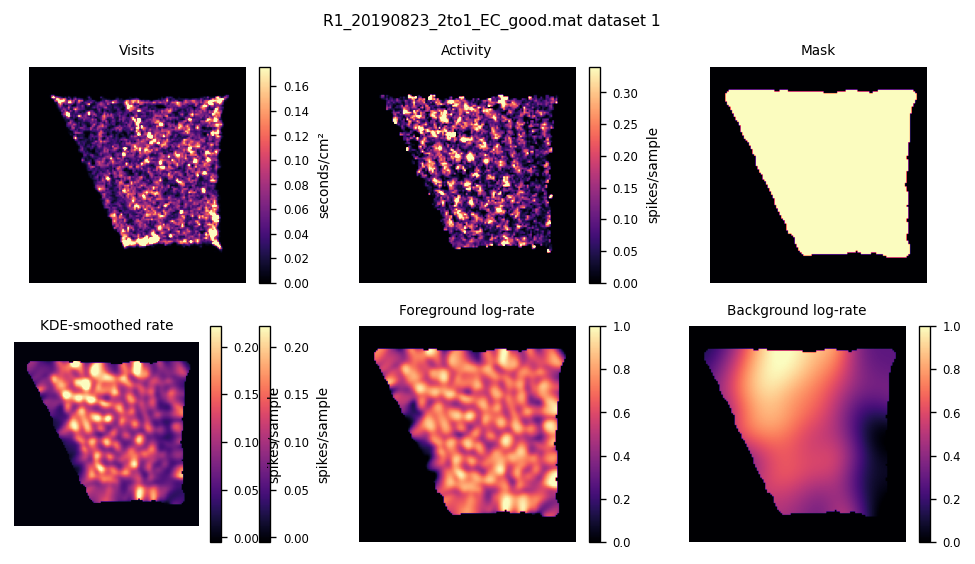

In [4]:
# Precompute variables; Passed as globals to jac/hess
fgσ  = P/pi           # In units of linear-bins
bgσ  = fgσ*5          # In units of linear-bins
n    = N.ravel()      # seconds/bin
y    = y.ravel()      # spikes/second within each bin
λhat = kdeλ(N,K,fgσ)  # KDE estimated rate
λbg  = kdeλ(N,K,bgσ)  # Background rate
lλh  = slog(λhat)     # Log rate
lλb  = slog(λbg)      # Log background
lλf  = lλh - lλb      # Foreground log rate

# Initial guess for kernel height
σ0   = zerolag(radial_acorr(lλf,mask))

figure(figsize=(7,4))
subplot(231)
title('Visits');
axis('off')
imshow(N*Δt/Δx,vmin=percentile(N*Δt/Δx,5),vmax=percentile(N*Δt/Δx,98));
colorbar(label='seconds/cm²')
subplot(232)
title('Activity');
axis('off')
imshow(y.reshape(L,L),vmin=percentile(y,1),vmax=percentile(y,98));
colorbar(label='spikes/sample')
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
title('KDE-smoothed rate');
axis('off')
imshow(λhat*mask,vmin=percentile(λhat,1),vmax=percentile(λhat,99));
colorbar(label='spikes/sample')
colorbar(label='spikes/sample')
subplot(235)
showim(lλf,'Foreground log-rate',mask=mask);
colorbar()
subplot(236)
showim(lλb,'Background log-rate',mask=mask);
colorbar()
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

In [5]:
rP   = 2
rβ   = 25
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 21
Nβ   = 21
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
βs   = float32(exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1])

ncomponents = 100

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])
    thr = sorted(abs(Kf).ravel(),reverse=True)[ncomponents]
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d  = use2d | use2d.T     # Ensure symmetric
R      = sum(use2d)
use    = find(use2d.ravel()) # Indecies into LxL array to use4
down   = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

# Streamline precomputation of low-rank collapse of diagonal matrix
f1e = fft(eye(L),norm='ortho')[use1d,:]
h2e = float32(RI(f1e[:,None,:,None]*f1e[None,:,None,:]).reshape(R1d*R1d,L*L)[usecut])

def Fu(u):
    # Operator to convert from full- to low-rank subspace
    # This must be semi-orthogonal and the Hermitian transpose of Ftu (below)
    return RI(fft2(float32(u).reshape(L,L),norm='ortho')[use2d])

def Ftu(u):
    # Operator to convert from low-rank to full space
    # This must be semi-orthogonal and the Hermitian transpose of Fu (above)
    x = zeros((L,L)+u.shape[1:],dtype='float32')
    x[use2d,...] = u
    return RI(fft2(x,norm='ortho',axes=(0,1))).reshape(L*L,*u.shape[1:])

F = LinearOperator((R,L*L),matvec=Fu,rmatvec=Ftu,rmatmat=Ftu)

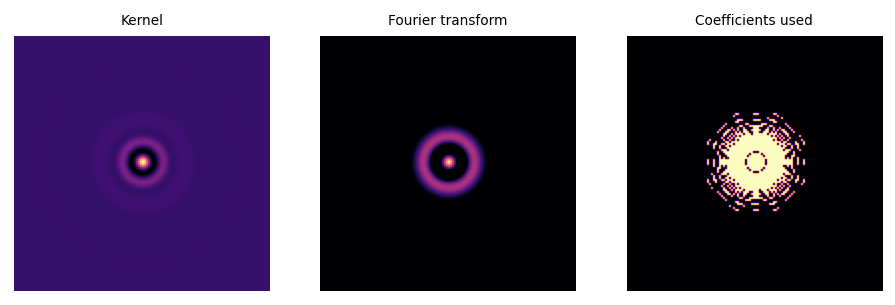

In [6]:
# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
def prepare_kernel(p,height):
    Kf = make_kernel_ft(L,p).real*height
    K0 = float32(ifft2(Kf).real)
    Kh = Kf[use2d]
    Λh = 1/Kh
    return (*map(float32,[K0,Kh,Λh]),)

K0,Kh,Λh = prepare_kernel(P,1)
subplot(131)
showkn(K0,'Kernel')
subplot(132)
showkn(RI(fft2(K0)),'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

Δt = 5504 ms  elapsed for took


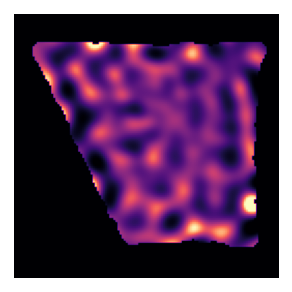

In [7]:
class diagonal_fourier_lowrank:
    
    def __init__(self,
                 n,y,μ0,L,R,use2d,F,h2e,σ0
                ):
        # Prepare kernel
        _,K,Λ = prepare_kernel(p,σ0)
        M = op(R,lambda u:K*u) #  Preconditioner, in low-rank space
        
        self.cached = (n,y,μ0,L,R,use2d,F,Λ,h2e,M)
        
        μ  = float32(lλf.ravel())
        μh = F@μ
        v  = μ*0
        self.μ0 = lambda:μh
        self.Σ0 = lambda:v

    def fast_low_rank_covariance(self,μh,v):
        n,y,μ0,L,R,use2d,F,Λ,h2e,M = self.cached
        nλ = n*exp(F.T@μh + μ0 + v/2, dtype='float32')
        x  = sqrt(nλ,dtype='float32')[None,:]*h2e
        C  = chinv(diag(Λ) + x@x.T)
        return C.T @ C

    def fast_covariance_diagonal(self,μh,v):
        n,y,μ0,L,R,use2d,F,Λ,h2e,M = self.cached
        nλ = n*exp(F.T@μh + μ0 + v/2, dtype='float32')
        x  = sqrt(nλ,dtype='float32')[None,:]*h2e
        A  = chinv(diag(Λ) + x@x.T)
        X  = zeros((L,L,R),dtype='float32')
        X[use2d] = A.T
        DF = RI(fft2(X,axes=(0,1),norm='ortho')).reshape(L**2,R).T
        #DF = (F.T@A.T).T
        return sum(DF**2,0,dtype='float32')

    def loss(self,μh,v):
        n,y,μ0,L,R,use2d,F,Λ,h2e,M = self.cached
        μ  = F.T@μh
        λ  = exp(μ + μ0 + v/2, dtype='float32')
        x  = sqrt(n*λ,dtype='float32')[None,:]*h2e
        C  = chinv(diag(Λ) + x@x.T)
        l1 =  n@(λ-y*μ)         #  n'(λ-y∘μ)
        l2 =  sum(μh**2*Λ)/2    #  ½μ'Λ₀μ
        l3 = -sum(log(Λ))/2     #  ½ln|Σ₀|
        l4 = -sum(log(diag(C))) # -½ln|Σ|
        l5 =  sum(C**2 * Λ)/2   #  ½tr[Λ₀Σ]
        return array([l1,l2,l3,l4,l5])

    def likelihood(self,μh,v):
        n,y,μ0,L,R,use2d,F,Λ,h2e,M = self.cached
        μ    =  F.T@μh
        λ    =  exp(μ + μ0 + v/2)
        nyλ  =  n@(y*μ - λ)
        nλ   =  n*λ
        μΛμ  =  sum(μh**2*Λ)
        Σq   =  self.fast_low_rank_covariance(μh,v)
        ldΣq =  logdet(Σq)
        ldΣz = -sum(slog(Λ))
        return nyλ - 0.5*(μΛμ + ldΣz - ldΣq)

    def JHvM(self,μh,v):
        n,y,μ0,L,R,use2d,F,Λ,h2e,M = self.cached
        μ  = F.T@μh
        λ  = exp(μ + μ0 + v/2, dtype='float32')
        J  = Λ*μh + F@(n*(λ-y))
        nλ = n*λ
        Hv = op(R,lambda u:Λ*u + F@(nλ*(F.T@u)))
        return J,Hv,M

    def mean_update(self,μh,v):
        J,Hv,M = self.JHvM(μh,v)
        return - minres(Hv,J,tol=mintol,M=M)[0]

    def variance_update(self,μh,v):
        return self.fast_covariance_diagonal(μh,v)-v
    
"""
def coerce_precision(x,precision='32',copy=False):
    '''
    Recursively cast to float32/complex64 or float64/complex128. This 
    compensates for numpy's aggressive promotion from 32→64 bit, while 
    preventing clutter elsewhere in the codebase.
    '''
    rt,ct = {
        '32' :(np.float32   ,np.complex64),
        '64' :(np.float64   ,np.complex128),
        '128':(np.longdouble,np.longcomplex),
    }[precision]
    if np.isrealobj(x):    return rt(x) if copy or x.dtype==rt else x
    if np.iscomplexobj(x): return ct(x) if copy or x.dtype==ct else x
    return (*map(coerce_float_type,x),)

def coordinate_descent(gp,
        maxiter      = 100,
        maxmeaniter  = 10,
        maxvariter   = 1,
        tol          = 1e-5,
        precision    = '32',
        showprogress = False):
    '''
    ----------------------------------------------------------------------------
    Abstract mean/variance coordinate descent subroutine
    
    Parameters
    ----------
    '''
    report = print if showprogress else lambda *x:()
    report('(checking arguments)')
    μ = coerce_precision(gp.μ0,copy=True)
    Σ = coerce_precision(gp.Σ0,copy=True)
    report('(optimizing)')
    εμ,εΣ = 0,0
    for i in range(maxiter):
        for j in range(maxmeaniter):
            Δμ = coerce_precision(gp.mean_update(μ,Σ),precision)
            εμ = np.max(abs(Δμ))
            report('εμ',εμ,'iteration',i,j)
            μ += Δμ
            if εμ<tol: break
        for j in range(maxvariter):
            ΔΣ = coerce_precision(gp.variance_update(μ,Σ),precision)
            εΣ = np.max(abs(ΔΣ))
            report('εΣ',εΣ,'iteration',i,j)
            Σ += ΔΣ
            if εΣ<tol: break
        if εΣ<tol and εμ<tol: break
    return μ,Σ,gp.loss(μ,Σ),gp.likelihood(μ,Σ)
"""

μ0    = float32(lλb.ravel())
foo = diagonal_fourier_lowrank(n,y,μ0,L,R,use2d,F,h2e,σ0)

tic()
μh,v,l,lpy = coordinate_descent(foo)
tic('took')
μ = F.T@μh
showim(exp((μ+v/2).reshape(L,L)),mask=mask)

In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


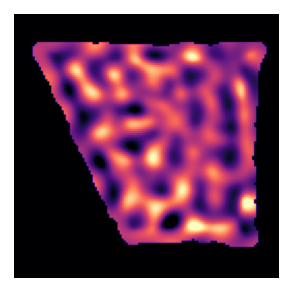

In [9]:
cv = μ/sqrt(v)
showim(cv.reshape(L,L),mask=mask)

# Sweep β and optimize 

In [10]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μh,v,_,lpy = infer(μh,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tlpy = ',lpy)
μhref,vref = μh,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    lpys    = array([-inf if r is None else np.sum(array(r[3])) for r in results.ravel()])
    bestidx = argmax(lpys)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, lpys[bestidx]  
def search(ip,iβ,suggested_direction=None):
    global results
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return
    
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    
    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μh1,v1),(μh2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μh = 2*μh1 - μh2
        v  = 2*v1  - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μh1,v1),(μh2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μh = 2*μh1 - μh2
        v  = 2*v1  - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μh,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μh,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μh,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μh,v = results[ip-1,iβ][:2]
    else: μh,v = μhref,vref
    
    β = βs[iβ]
    μh,v,l,lpy = infer(μh,v,float(β),float(p))
    results[ip,iβ] = (μh,v,l,lpy)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f lpy=%f'%(ip,Ps[ip],iβ,βs[iβ],np.sum(array(l)),lpy))
    clear_output(wait=True)
    figure()
    imshow(array([r[3] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Δp,Δβ = suggested_direction
        if current_best()[:2]==(ip,iβ):
            search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
            search_directions -= {(Δp,Δβ)}
    # Try other trajectories
    for Δp,Δβ in search_directions:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
    return

ip = NP//2
iβ = Nβ//2
search(ip,iβ)

notify('DONE')

NameError: name 'infer' is not defined

In [ ]:
bestP, bestβ = current_best()[:2]
μh,v,l,lpy = results[bestP,bestβ]
μ = up(μh)
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

In [ ]:
print(Ps[bestP], βs[bestβ])

# Further analyses

To continue where we left off in the paper, we now need to:

- Infer maps for a range of angles
- Sample to show posterior

# Sampling from the posterior

In [ ]:
μ  = up(μh)
λ  = exp(μ + μ0 + v/2)
nλ = n*λ
Σq = fast_low_rank_covariance(nλ,β,p)
Cq = float32(chol(Σq))

In [ ]:
nsamples = 1000
q = μh[:,None] + Cq@float32(randn(R,nsamples))
bigger = zeros((L,L,nsamples),dtype='float32')
bigger[use2d,:] = q
bigger = fft2(bigger,axes=(0,1),norm='ortho')
bigger = bigger.real + bigger.imag
λ = exp(μ0.reshape(L,L)[:,:,None] + bigger)
imshow(λ[:,:,100]*mask)
print(mean(λ.reshape(L*L,nsamples)[mask.ravel()]), mean(y.ravel()[mask.ravel()]))

In [ ]:
resolution = 4

def fftupsample2d(q,F=4):
    h,w = q.shape
    Q = fftshift(fft2(q))*F
    Q2 = np.complex128(zeros((h*F,w*F)))
    c0 = (h*F)//2-h//2
    r0 = (w*F)//2-w//2
    Q2[c0:c0+h,r0:r0+w] = Q
    return real(ifft2(fftshift(Q2)))*F

def findpeaks(q,th=-inf,r=1):
    # Local maxima > th in square neighborhood radius r. 
    # Treats first two dimensions as (x,y) spatial dimensions
    L  = q.shape[0]
    D  = 2*r
    Δ  = range(D+1)
    q0 = q[r:-r,r:-r,...]
    p  = q0>th
    for i,j in {(i,j) for i in Δ for j in Δ if i!=r or j!=r}:
        p &= q0>q[i:L+i-D,j:L+j-D,...]
    p2 = zeros(q.shape,bool)
    p2[r:-r,r:-r,...] = p
    return p2

In [ ]:
bigmask = fftupsample2d(mask,resolution)>0.1

# Extract peaks
all_pxy = []
all_φs  = []

pxy_=[]
for i,λi in progress_bar(enumerate(λ.T)):
    m = fftupsample2d(λi,resolution)
    pxy = array(where((findpeaks(m,th=mean(m)+std(m)*0.5)*bigmask).T))
    pxy_.append(pxy)

In [ ]:
px,py = zip(*pxy_)
px = array(concatenate(px)).ravel()/resolution/L
py = array(concatenate(py)).ravel()/resolution/L
J = histogram2d(px,py,(bins,bins),density=False)[0]/nsamples
J[J<0.05]=0
ry,rx = where(findpeaks(J*mask))
J2 = copy(J)
J2[~mask]=nan
figure(dpi=300,figsize=(6,2))
subplot(131)
showim(J2)
scatter(rx,ry,facecolor=(0,)*4,edgecolor=(0.8,)*4,lw=0.4,s=25)
subplot(132)
showim(y.reshape(L,L)*(1/mask))
#J2[J2<=0]=NaN
#imshow(slog(J2),cmap='turbo')
scatter(rx,ry,facecolor=(0,)*4,edgecolor=(1,)*4,lw=.5,s=3)
subplot(133)
showim(exp(μ+μ0+v/2).reshape(L,L)*(mask))
#J2[J2<=0]=NaN
#imshow(slog(J2),cmap='turbo')
scatter(rx,ry,color=(0.,)*3,lw=0.4*1.5,s=5,marker='+')
scatter(rx,ry,color=(0.8,)*3,lw=0.4,s=5,marker='+')
tight_layout()


In [ ]:
imshow(μ.reshape(L,L)/sqrt(v.reshape(L,L)))

# Infer maps for a range of angles 

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))